In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_dir = '/content/drive/MyDrive/CAPTCHA/captchas'

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn



all_files = [f for f in os.listdir(data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]






In [5]:
import string

# Define the character set (e.g., lowercase letters + digits)
characters = string.ascii_lowercase + string.digits
char_to_idx = {char: idx for idx, char in enumerate(characters)}

# This function will encode each character of a label as its index
def encode_label(label):
    return [char_to_idx[char] for char in label]


In [6]:

images = []
labels = []

for img_file in all_files:
    label = os.path.splitext(img_file.split('_')[1])[0].lower()
    img_path = os.path.join(data_dir, img_file)
    image = Image.open(img_path).convert('L')  # Convert to grayscale
    image = image.resize((250, 50))  # Resize to consistent shape
    images.append(np.array(image))
    labels.append(encode_label(label))  # Convert label to list of indices


# NumPy arrays
images = np.array(images)/255.0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [7]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 50, 250)
        self.labels = torch.tensor(labels, dtype=torch.long)  # shape: (N, 5)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]  # label is a sequence


In [8]:
train_dataset = CustomDataset(X_train, y_train)

In [9]:
test_dataset = CustomDataset(X_test, y_test)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [11]:
class Resblock(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Resblock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample


    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

In [12]:
class ResNetCaptcha(nn.Module):
    def __init__(self, layers, num_classes=36, captcha_length=6):
        super(ResNetCaptcha, self).__init__()
        self.in_channels = 64
        self.captcha_length = captcha_length
        self.dropout = nn.Dropout(0.3)



        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64,  layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        feature_dim = 512 * Resblock.expansion
        self.classifiers = nn.ModuleList([
            nn.Linear(feature_dim, num_classes) for _ in range(captcha_length)
        ])

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * Resblock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * Resblock.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * Resblock.expansion)
            )

        layers = [Resblock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * Resblock.expansion

        for _ in range(1, blocks):
            layers.append(Resblock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)

        x = self.dropout(x)

        outputs = [classifier(x) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)


In [13]:
import torch.optim as optim

epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layers = [3, 4, 6, 3]

model = ResNetCaptcha(layers=layers)
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


train_epoch_losses = []
train_exact_match_accuracies = []

for epoch in range(epochs):
    total_epoch_loss = 0
    correct_full = 0
    total = 0

    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)


        outputs = model(batch_features)

        # Assuming outputs are of shape [batch_size, captcha_length, num_classes]
        # print(outputs.shape)  # Should be [batch_size, captcha_length, num_classes]
        # print(batch_labels.shape)  # Should be [batch_size, captcha_length]

        # # Reshape outputs and labels to match CrossEntropyLoss expectations
        # outputs = outputs.view(-1, outputs.shape[-1])  # Flatten the captcha_length dimension
        # batch_labels = batch_labels.view(-1)  # Flatten the captcha_length dimension


        # Compute loss
        loss = criterion(outputs.view(-1, outputs.shape[-1]), batch_labels.view(-1))


        optimizer.zero_grad()
        loss.backward()


        optimizer.step()

        total_epoch_loss += loss.item()

          # Compute exact match accuracy
        with torch.no_grad():
            predicted = torch.argmax(outputs, dim=2)  # [batch_size, captcha_length]
            correct_full += (predicted == batch_labels).all(dim=1).sum().item()
            total += batch_labels.size(0)

    exact_match_acc_train = correct_full / total
    avg_loss_train = total_epoch_loss / len(train_loader)
    train_epoch_losses.append(avg_loss_train)
    train_exact_match_accuracies.append(exact_match_acc_train)
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss_train}')


Epoch: 1, Loss: 3.3230948247909544
Epoch: 2, Loss: 3.2361164817810057
Epoch: 3, Loss: 2.9421387062072752
Epoch: 4, Loss: 2.448337613105774
Epoch: 5, Loss: 1.9678044419288636
Epoch: 6, Loss: 1.531935585975647
Epoch: 7, Loss: 1.1800109791755675
Epoch: 8, Loss: 0.9580043959617615
Epoch: 9, Loss: 0.8535511012077331
Epoch: 10, Loss: 0.8003803825378418


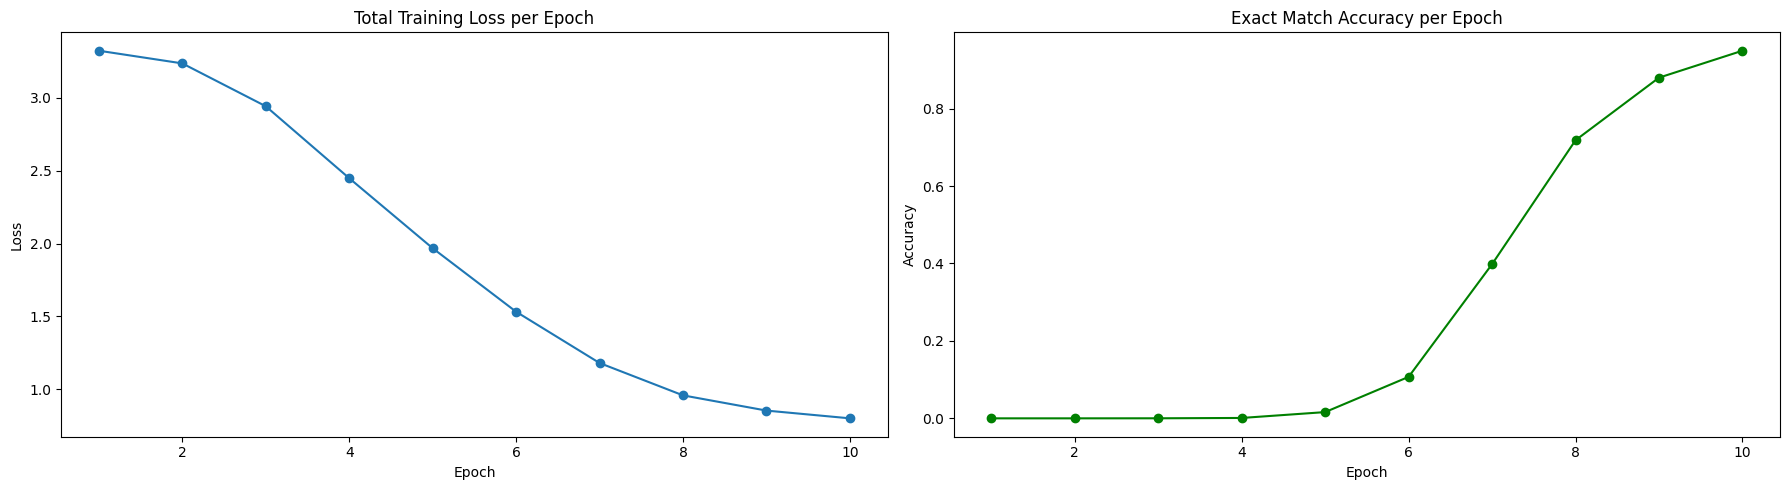

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

epoch_list = [1,2,3,4,5,6,7,8,9,10]

plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_epoch_losses, marker='o')
plt.title('Total Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_exact_match_accuracies, marker='o', color='green')
plt.title('Exact Match Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.tight_layout()
plt.show()


In [15]:
total = 0
correct = 0
char_total = 0
char_correct = 0

model.eval()
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)  # [batch_size, captcha_length, num_classes]
        predicted = torch.argmax(outputs, dim=2)  # [batch_size, captcha_length]

        # Exact match (full captcha correct)
        correct += (predicted == batch_labels).all(dim=1).sum().item()
        total += batch_labels.size(0)

        # Character-wise accuracy
        char_correct += (predicted == batch_labels).sum().item()
        char_total += batch_labels.numel()  # total characters = batch_size * captcha_length

exact_match_acc_test = correct / total
char_level_acc_test = char_correct / char_total

print(f"Exact Match Accuracy: {exact_match_acc_test:.4f}")
print(f"Character-wise Accuracy: {char_level_acc_test:.4f}")


Exact Match Accuracy: 0.7066
Character-wise Accuracy: 0.9418


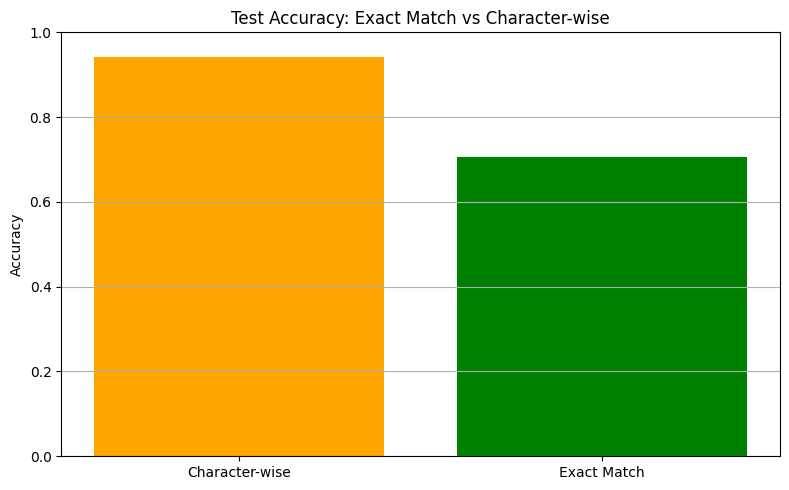

In [16]:
import matplotlib.pyplot as plt

test_char_accuracy = [char_level_acc_test]
test_exact_match_accuracies = [exact_match_acc_test]

labels = ['Character-wise', 'Exact Match']
accuracies = [test_char_accuracy[0], test_exact_match_accuracies[0]]
x = range(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x, accuracies, color=['orange', 'green'])
plt.xticks(x, labels)

plt.title('Test Accuracy: Exact Match vs Character-wise')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [17]:
checkpoint_path = "resnet_captcha_model.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Model saved to {checkpoint_path}")


Model saved to resnet_captcha_model.pth


In [18]:
from IPython.display import FileLink
FileLink("resnet_captcha_model.pth")


/content/resnet_captcha_model.pth